# MScA Capstone Project

# Leveraging Structured and Unstructured Data for Foreign Exchange Price Movement Forecasting

**Author - Targoon Siripanichpong, Kevin Niemi, Piyush Sanghi**

## Introduction

**Background**

Trade Tools Technology Inc., headquartered in Chicago, IL, has been providing trading technology solutions for a variety of clients across the world for the past 14 years.  It is currently serving over 50 enterprise clients across the globe providing trading platforms and trade analytics for currency exchange and crypto-currency trading.  

Trade Tools Technology is providing trading platforms to facilitate trades of currency exchange and crypto-currency trading. Trade Tools current algorithms are based predominantly on the transactional data and general market fundamentals, available from the commercial providers. The company is looking to strengthen its analytical offerings by leveraging advanced machine learning algorithms and tapping into the rich sources of unstructured data (i.e. news articles). The company believes that unlocking insights from unstructured data, such as social unrest, natural disasters, government and policy changes will enable it to provide better analytical services to the clients and consequently grow subscription revenue. 

**Research Purpose**

The objective of this research is to forecast Foreign Exchange price movement one hour in advance for a currency pair, namely EUR/USD, by leveraging the sentiments of global events and their impacts. Global events are determined by collecting, classifying, and filtering news feeds based on topics relating to social unrests, natural disasters, and government policy changes in real time. These data will be collected based on predefined relevant keywords and sources, which develop over time through an iterative design process. The features extracted from text data will be used in conjunction with historical prices, order books, and keyword search popularity (Google Trends) to predict the Foreign Exchange price movements.

The performance of this model will be compared against the performance of the baseline time-series model. Assuming a relationship exists between currency movement and features from the news feeds, a model is expected to add predictive power to the baseline model.

## Data/Variable Definition & Collection

The following datasets are leveraged to build the Foreign Exchange Forecasting Model:

**Internal Data**

Internal data are data provided by TradeTools FX. Moving forward, these data will be harvested using API called to TradeTools FX servers.

* Historical Price Data - Historical exchange rates collected in a one-hour interval. EUR/USD is the currency pair that will be examined. Three other currency pairs are used for validation purpose. The raw data are provided on a minute-by-minute basis, dating back to January 2001.

* Trade Volume Data - Transactions listed and placed on the Trade Tools FX trading server with price, volume, date and time.

**External Data**

External data are collected via scraping. Scheduled scripts are created running on an hourly basis to scrape the data and store them in the data store. Two external data sources are:

* Google Trends - Google Trends data for the keywords defined in the dictionary are collected programmatically on an hourly interval. 

* News Feeds Data - Historical news archives where news title containing words from the Data Dictionary - dating back to January 2017 up until September 2019.



### Internal Data 

Each model has a specific preprocessing method. Data path for the historical price data is below:

#### Historical Price

In [1]:
### Currency
currency_data_path = "/project/msca/projects/ForexPrediction/data/Currencies/"
currency_data_filename = "EURUSD.txt"

An example of the data can be seen below:

In [2]:
with open(currency_data_path + currency_data_filename) as fp:
    line = fp.readline()
    cnt = 1
    while cnt < 10:
        print("Line {}: {}".format(cnt, line.strip()))
        line = fp.readline()
        cnt += 1

Line 1: <TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
Line 2: EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
Line 3: EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
Line 4: EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
Line 5: EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
Line 6: EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4
Line 7: EURUSD,20010102,230600,0.9506,0.9506,0.9506,0.9506,4
Line 8: EURUSD,20010102,230700,0.9505,0.9507,0.9505,0.9507,4
Line 9: EURUSD,20010102,230800,0.9507,0.9507,0.9507,0.9507,4


The data, again, will be preprocessed during the modeling process.

#### Trade Volume

In [3]:
### Trade records
trade_data_path = '../Data/TradeOrder/'
trade_filename = 'EURUSD Orders.csv'

In [4]:
with open(trade_data_path + trade_filename) as fp:
    line = fp.readline()
    cnt = 1
    while cnt < 10:
        print("Line {}: {}".format(cnt, line.strip()))
        line = fp.readline()
        cnt += 1

Line 1: Order;Symbol;Command;Volume;OpenPrice;OpenTime;ClosePrice;CloseTime;Profit
Line 2: 14208215;EURUSD;Sell;0.2;1.12001;7/16/2019 8:41:09 PM;1.12057;7/16/2019 9:50:41 PM;-10
Line 3: 14218226;EURUSD;Sell;0.01;1.12365;7/18/2019 10:52:40 AM;1.12402;7/18/2019 11:09:49 AM;-0.33
Line 4: 14218526;EURUSD;Sell;0.01;1.12367;7/18/2019 11:57:12 AM;1.1239;7/18/2019 11:57:16 AM;-0.2
Line 5: 14281070;EURUSD;Buy;0.01;1.11349;7/26/2019 2:17:17 PM;1.11297;7/26/2019 2:34:45 PM;-0.47
Line 6: 14285916;EURUSD;Sell;0.01;1.11214;7/26/2019 8:21:34 PM;1.11269;7/26/2019 8:51:47 PM;-0.49
Line 7: 14276728;EURUSD;Buy;1;1.11483;7/26/2019 12:05:00 AM;1.11483;7/26/2019 12:05:01 AM;0
Line 8: 12641112;EURUSD;Buy;1;1.14707;8/10/2018 12:34:22 PM;1.13698;8/13/2018 12:00:32 AM;-1009
Line 9: 12641113;EURUSD;Buy;0.5;1.14701;8/10/2018 12:34:35 PM;1.16;8/22/2018 2:10:46 PM;649.5


Some data manipulation is required to aggregated trade volume into an hourly grain. <code>TradeVolumeAggregation.py</code> module is created to aggregated data into an hourly grain.

In [5]:
import TradeVolumeAggregation
ST_DT = '2018-07-27 00:00:00'
END_DT = '2019-08-02 12:00:00'
Trade_Vol = TradeVolumeAggregation.TradeVolumeAggregation(trade_data_path, trade_filename, ST_DT, END_DT)
Trade_Vol.Aggregate()

After aggregation, the data are transformed, as shown below:

In [6]:
Trade_Vol.aggregated_trade_vol.head()

,ActualVolume_Sell,ActualVolume_Buy
OpenTime,,
2018-07-27 06:00:00,NaN,20000.0
2018-07-27 07:00:00,90000.0,10000.0
2018-07-27 08:00:00,5000.0,101000.0
2018-07-27 09:00:00,4000.0,35000.0
2018-07-27 10:00:00,2000.0,10000.0


Define the saved file path for Trade Volume for additional preprocessing and data modeling.

In [7]:
### Aggregated Buy/Sell Volumes
buysell_vol_data_path = '../Data/'
buysell_vol_filename = 'EURUSD_aggregated_orders_with_features.csv'

### External Data

#### Google Trends

Two scrapers are used to collect Google Trends data. The first one, using **pytrends** API, is collecting data for two-week period at a time on an hourly basis. The hourly scraper is called <code>GoogleTrendsHistoricalData.py</code>. 

The example of the command line prompt to call the script is as follows. Please note that in the scheduler, you will need to specify the start/end dates, as well as the geolocation.

<code>!nohup python3 -u GoogleTrendsHistoricalData.py -s 2018-10-01-0 -e 2019-04-08-23 -g US > nohup.out & </code>

The other scraper used to collect Google Trends data is compiling the data for a longer period of time (6 months). The data grain is on a daily basis. This scraper leverages a Selenium Driver and Chrome Browser to collect the data; and therefore, a Chrome browser and a chromedriver are needed. The daily scraper is called <code>GoogleTrendsUIScraper.py</code>

Once the data have been collected from both sources, they will need to be combined and normalized. The script to normalize the data is called: <code>GoogleTrendsNormalization.py</code>

In [8]:
from GoogleTrendsNormalization import GoogleTrendsNormalization
hourly_path = '../Data/GoogleTrends/Hourly Data/'
daily_path = '../Data/GoogleTrends/Daily Data/'
GoogleTrends = GoogleTrendsNormalization(hourly_path, daily_path, '../Data/GoogleTrends/google_trends_aggregated.csv')
GoogleTrends.Normalize()

File successfully saved at ../Data/GoogleTrends/google_trends_aggregated.csv


In [9]:
GoogleTrends.normalized_score.head()

,Coup_score,reserves_score,surpluses_score,Australian Dollar_score,Insurgency_score,Corruption_score,Sanction_score,Storm_score,Fed_score,rioting_score,...,Tariff_score,Drought_score,Justice department_score,NRA_score,Asylum_score,President_score,Civil War_score,Protest _score,Federal Reserve_score,Shooting_score
2018-10-01 00:00:00,1377,420,0.0,0,0,0,0,682,341,0,...,1005,0,1407,442,0,391,1891,114,297,546
2018-10-01 01:00:00,0,0,0.0,0,0,3240,0,868,496,0,...,938,460,5360,1292,380,374,1342,171,0,1246
2018-10-01 02:00:00,0,0,0.0,1600,0,1296,882,2015,186,0,...,2010,0,469,1360,0,272,488,228,0,1008
2018-10-01 03:00:00,4845,0,0.0,0,0,1539,1029,1085,217,0,...,1206,598,536,544,494,272,549,209,675,742
2018-10-01 04:00:00,2091,980,0.0,0,0,3321,1372,961,806,0,...,804,0,737,0,608,204,2196,171,0,630


Define the saved file path for Google Trends for additional preprocessing and data modeling.

In [10]:
### Google Trends
google_trends_data_path = "../Data/GoogleTrends/"
google_trends_filename = "google_trends_aggregated.csv"

#### News Feed

This is the scraper used to scrape news from **WebHose.io**. The API key is required to make the call, which can be adjusted from the <code>webhose_configs.py</code> script. The script file for Webhose scraper is called: <code>webhose_scraper.py</code>. To run the script, the following command can be used.

<code>python3 /project/msca/projects/ForexPrediction/capstone/Scripts/webhose_scraper.py</code>

News feed is stored as JSON files. Each JSON file contains one article. Since there will be multiple JSON files, the news data path is required. The preprocessing method in the modeling process will handle the files and aggregate them. The data file path is required.

In [11]:
### News Feed Data
text_data_path = '/project/msca/projects/ForexPrediction/data/WebHose/'

Here is an example of a JSON file.

In [12]:
import os
import pandas as pd
import json

files = os.listdir(text_data_path)
files = [file for file in files if (file.endswith('.json'))]

with open(text_data_path + files[1]) as f:
    data = json.load(f)
    news_df = pd.DataFrame(data)
news_df.head()

,author,crawled,entities,external_images,external_links,highlightText,highlightTitle,language,ord_in_thread,published,rating,text,thread,title,url,uuid
0,,2019-05-26T01:05:11.002+03:00,{'persons': [{'name': 'kate middleton meet don...,[],[https://express.co.uk/news/royal/1131385/Kate...,,,english,0,2019-05-25T22:26:00.000+03:00,None,Will Prince William and Kate Middleton Meet Do...,{'uuid': '01947ba7b864da9975259afed27f55ee5338...,Will Prince William and Kate Middleton Meet Do...,https://ca.style.yahoo.com/prince-william-kate...,01947ba7b864da9975259afed27f55ee53381c79
1,,2019-05-26T01:10:35.015+03:00,"{'persons': [{'name': 'gholam ali rashid', 'se...",[],[],,,english,0,2019-05-26T03:00:00.000+03:00,None,"Roundup: Iran's IRGC vows to respond ""firmly"" ...",{'uuid': '0ff8d798c0e85da3b0cf7ec3b8ea3250cd38...,"Roundup: Iran's IRGC vows to respond ""firmly"" ...",http://www.xinhuanet.com/english/2019-05/26/c_...,0ff8d798c0e85da3b0cf7ec3b8ea3250cd38eabc
2,deseretnews.com,2019-05-26T01:15:03.011+03:00,"{'persons': [{'name': 'russell m. nelson', 'se...",[],[https://www.thechurchnews.com/leaders-and-min...,,,english,0,2019-05-25T23:58:00.000+03:00,None,Church News President Russell M. Nelson visits...,{'uuid': '119541a13b0d8e1b16c3bdf85047f12d3352...,Watch: President Russell M. Nelson shares his ...,https://www.deseretnews.com/article/900072440/...,119541a13b0d8e1b16c3bdf85047f12d335258aa
3,Michelle He,2019-05-26T01:15:32.002+03:00,"{'persons': [{'name': 'thomas graham', 'sentim...",[],"[http://ir.ltbridge.com/alerts.cfm, https://gl...",,,english,0,2019-05-23T13:30:00.000+03:00,None,"RESTON, Va., Lightbridge Corporation (NASDAQ: ...",{'uuid': '291c7e4c7cc828cae04d765ab008e5f7f574...,Lightbridge Executive Chairman Ambassador Thom...,https://www.financialbuzz.com/lightbridge-exec...,291c7e4c7cc828cae04d765ab008e5f7f574d314
4,View All Posts Tom Luongo,2019-05-26T01:30:39.000+03:00,"{'persons': [{'name': 'nigel farage', 'sentime...",[],[https://www.apc01.safelinks.protection.outloo...,,,english,0,2019-05-24T03:00:00.000+03:00,None,"Date: May 24, 2019 Author: Tom Luongo 0 Commen...",{'uuid': '8f8ed987296ccef783cf96c0d8f8ad2cc48b...,Nigel Farage Takes Down Another Tory Governmen...,https://tomluongo.me/2019/05/24/nigel-farage-t...,8f8ed987296ccef783cf96c0d8f8ad2cc48be52a


## Data Modeling

Two different engines are used to constructed the full classification models. The first engine, which is the main classification engine, takes in structured data, which are price history, transactions, and Google Trends as inputs and classifies price movement - up/steady/down for multiclass classification. This model will be referred to as the price movement model.

The second engine, which will be referred to as a event detection model, takes in the unstructured text data, transforms them into structured data, and then classifies whether the price change is significant. The output from the price change detection engine will be fed into the main classification engine. The idea behind this engine is that it is the frequency of word appearances would provide an indication on the trending topic at that time. 

We will look into the event detection model first, as its output will be fed into the price movement model.

In [13]:
#import libraries
import os
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import pickle
import json
import xgboost as xgb
import EventDetectionModel
import PriceChangeMovementModel

### Event Detection Model

We will define some parameters for the model training timeline, as well as the model training parameters.

In [14]:
#Event Detection Model
START_DT = '2017-09-01 00:00:00'
END_DT = '2019-03-31 23:00:00'
pct = 0.01 # Threshold for the price movement

### Keywords
keyword_path = '../Data/'
keyword_filename = 'keyword.txt'

## Model Training
param = {'alpha': 0,
 'colsample_bytree': 0.25,
 'eval_metric': ['auc'],
 'feature_selector': 'thrifty',
 'gamma': 10,
 'lambda': 15,
 'learning_rate': 0.05,
 'max_depth': 5,
 'nthread': 12,
 'objective': 'binary:logistic',
 'subsample': 0.25}

We will first preprocess the data. The two data sources for the event detection model are the historical price and the text data, both of which we have defined the data path at the beginning of this notebook. The historical price is used to define the dependent variable (if the price movement is significant.) The news feed data are used as predictors.

In [15]:
## Data Preprocessing - Currency
data_event_detection = EventDetectionModel.EventDetection_DataPreprocessing(START_DT,END_DT)
data_event_detection.Currency_Preprocessing(currency_data_path, currency_data_filename, pct)
data_event_detection.hourly_currency_data.head()

,TICKER,DATE,TIME,CLOSE,DATE_TIME,RETURN,RETURN_PCT,LABEL
2017-09-01 00:00:00,EURUSD,20170901.0,0.0,1.1907,2017-09-01 00:00:00,0.004651,0.008398,0
2017-09-01 01:00:00,EURUSD,20170901.0,10000.0,1.1908,2017-09-01 01:00:00,-0.009302,-0.016798,0
2017-09-01 02:00:00,EURUSD,20170901.0,20000.0,1.1906,2017-09-01 02:00:00,-0.009302,-0.016801,0
2017-09-01 03:00:00,EURUSD,20170901.0,30000.0,1.1904,2017-09-01 03:00:00,-0.023256,-0.042020,-1
2017-09-01 04:00:00,EURUSD,20170901.0,40000.0,1.1899,2017-09-01 04:00:00,-0.018605,-0.033628,-1


The text data are transformed by creating a term-document matrix. The term-document matrix compiles the frequency of terms that occur in a collection of documents, which in this case are the news article titles. In this case, the terms that we focus on are the keywords, reducing the number of terms that would show up in the matrix significantly. Then, the lags of each time series for each keyword, up to 24 hours, are created.

In [16]:
## Data Preprocessing - Text
#data.Text_Preprocessing(text_data_path, keyword_path, keyword_filename)
# Since parsing through text data will take a while, we are loading the pre-built dataframe instead.
data_event_detection.news_data = pd.read_pickle('../Data/agg_news_score.pkl') 
data_event_detection.news_data.head()

,index,earthquake,flood,tsunami,global warm,typhoon,blizzard,snow storm,climate change,tornado,...,rebel,civil unrest,activis,hunger,poverty,shooting,nra,attack,coup,strike
crawled_round,,,,,,,,,,,,,,,,,,,,,
2017-08-31 22:00:00,42434093,1,12,0,0,0,0,0,2,0,...,0,0,1,0,0,4,0,4,5,0
2017-08-31 23:00:00,37486952,0,16,0,0,0,0,0,1,0,...,0,0,0,1,0,5,0,12,1,0
2017-09-01 00:00:00,28539286,0,16,0,0,0,0,0,2,0,...,0,0,0,0,0,1,0,2,0,1
2017-09-01 01:00:00,32767940,0,25,0,0,0,1,0,2,0,...,0,0,8,0,0,5,0,2,0,0
2017-09-01 02:00:00,30264534,0,32,0,0,0,0,0,0,1,...,0,0,2,0,1,6,1,6,2,0


Once the data are loaded, the data will be combined into one data source.

In [17]:
## Data Aggregation
data_agg_event_detection = EventDetectionModel.EventDetection_DataAggregation(data_event_detection.hourly_currency_data, 
                                                                              news_data=data_event_detection.news_data)
data_agg_event_detection.Get_EventModelData(keyword_path, keyword_filename)
data_agg_event_detection.event_model_data.head()

,LABEL,earthquake_1,flood_1,tsunami_1,global warm_1,typhoon_1,blizzard_1,snow storm_1,climate change_1,tornado_1,...,rebel_24,civil unrest_24,activis_24,hunger_24,poverty_24,shooting_24,nra_24,attack_24,coup_24,strike_24
2017-09-01 00:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-01 01:00:00,0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-01 02:00:00,0,0.0,25.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-01 03:00:00,-1,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-01 04:00:00,-1,0.0,25.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The **LABEL** column is the target variable while the rest of the columns, which are the lags of the document-term matrix, are the predictors.

The model is then trained using an XGBoost model, with the hyperparameters defined earlier. We splitted the model chronologically at 85:15 ratio for a train and test dataset.

In [18]:
## Model Training
model_train_event_detection = EventDetectionModel.EventDetection_ModelTraining(data_agg_event_detection.event_model_data)
model_train_event_detection.train_test()
model_train_event_detection.training(param)

[0]	train-auc:0.616486	eval-auc:0.614686
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.653094	eval-auc:0.660504
[2]	train-auc:0.670647	eval-auc:0.680023
[3]	train-auc:0.687089	eval-auc:0.707991
[4]	train-auc:0.694163	eval-auc:0.714212
[5]	train-auc:0.693085	eval-auc:0.712507
[6]	train-auc:0.698019	eval-auc:0.712995
[7]	train-auc:0.702289	eval-auc:0.713142
[8]	train-auc:0.704064	eval-auc:0.717583
[9]	train-auc:0.705142	eval-auc:0.721364
[10]	train-auc:0.709331	eval-auc:0.725016
[11]	train-auc:0.709011	eval-auc:0.724255
[12]	train-auc:0.709634	eval-auc:0.726505
[13]	train-auc:0.711226	eval-auc:0.726293
[14]	train-auc:0.713813	eval-auc:0.727464
[15]	train-auc:0.715185	eval-auc:0.726804
[16]	train-auc:0.716759	eval-auc:0.727697
[17]	train-auc:0.717535	eval-auc:0.72798
[18]	train-auc:0.718577	eval-auc:0.726962
[19]	train-auc:0.71888	eval-auc:0.728177
[20]	train-auc:0.719745	eval-au

We can check the model performance by getting the prediction for the train and test dataset.

In [19]:
prediction_event_detection_train = EventDetectionModel.EventDetection_Prediction(model_train_event_detection.model, model_train_event_detection.X_train)
print(prediction_event_detection_train.y_predict)

prediction_event_detection_test = EventDetectionModel.EventDetection_Prediction(model_train_event_detection.model, model_train_event_detection.X_test)
print(prediction_event_detection_test.y_predict)

[0.49395463 0.505025   0.6117913  ... 0.534159   0.5290207  0.5394025 ]
[0.5816604  0.64368063 0.6430129  ... 0.3359791  0.33939    0.3232963 ]


ROC AUC Curve is plotted below to show the model performance.

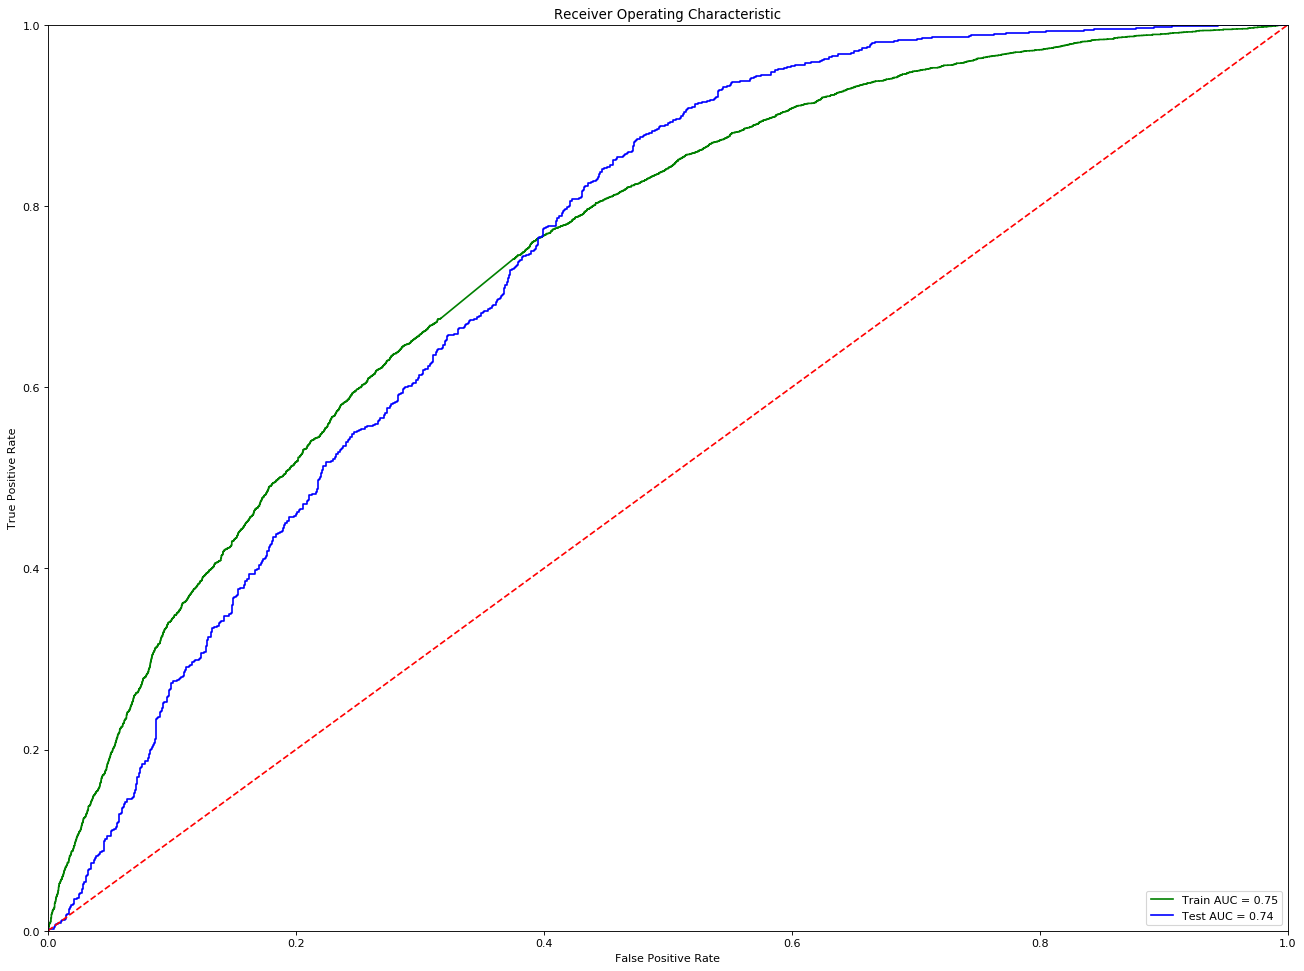

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, average_precision_score, f1_score

fpr_train, tpr_train, threshold_train = roc_curve(model_train_event_detection.y_train, prediction_event_detection_train.y_predict)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, threshold_test = roc_curve(model_train_event_detection.y_test, prediction_event_detection_test.y_predict)
roc_auc_test = auc(fpr_test, tpr_test)
%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'g', label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Once the model is trained and the results are satisfied, we are making the prediction for the whole dataframe to get the model output. This will be saved as a pickle file to be used in the pric movement model.

In [21]:
## Model Prediction
prediction_event_detection = EventDetectionModel.EventDetection_Prediction(model_train_event_detection.model, model_train_event_detection.X)
print(prediction_event_detection.y_predict)
prediction_event_detection.predicted_dataframe.to_pickle('../Data/text_label_prediction.pkl')

[0.49395463 0.505025   0.6117913  ... 0.3359791  0.33939    0.3232963 ]


### Price Movement Model

**Regression vs Binary Classification vs Multiclass Classification**

Three different approaches were considered in the modeling framework. From a simplistic point of view, the problem can be modeled with the price movement (up/down) as a target variable. However with this approach, the slightest increase in price would have the same magnitude as an exponential increase in price, because it would be denoted by the same label, “up”, when the loss is calculated. Therefore, the model was highly susceptible to small fluctuation and noise.

At the other end of the spectrum, regression fully takes the magnitude of the price change into account, resulting in the most accurate loss representation during the model training. However, after multiple regression models had been iterated, it was found that the level of forecasting accuracy was extremely low. This is most likely due to the high volatility of the time-series, and as a result, a random walk model is the best in forecasting price changes. Therefore, a regression model was not considered as a part of the findings.

In order to help stabilize the model from noise and volatility, a multiclass classification approach was explored. With this approach, price movement directions (up/down) are still evaluated. However, if the price difference falls below a certain threshold, then the price movement is considered “steady” instead. While this model may not be able to forecast the price direction at all time steps, the model is more robust against noise and price volatility. For both classification models, categorical cross-entropy loss was used as a loss metric in order to train the model.

We will define some parameters for the model training timeline, as well as the model training parameters.

In [22]:
# Price Movement Model

START_DT = '2018-10-01 00:00:00'
END_DT = '2019-03-31 23:00:00'
pct = 0.01

### Event Detection Model Result
event_model_data_file_path = '../Data/'
event_model_data_filename = 'text_label_prediction.pkl'

## Model Training Parameters
param = {'alpha': 0,
 'colsample_bytree': 0.25,
 'eval_metric': ['merror'],
 'feature_selector': 'thrifty',
 'gamma': 10,
 'lambda': 15,
 'learning_rate': 0.01,
 'max_depth': 8,
 'nthread': 12,
 'objective': 'multi:softprob',
 'num_class' : 3,
 'subsample': 0.25}

Similar to the event detection model, we will preprocess the data. In this case, we will preprocess the historical price data, aggregated Google Trends data, and the trade volume data. We will also load in the result from the event detection model.

In [23]:
## Data Preprocessing
### Historical Data
data = PriceChangeMovementModel.PriceChangeMovement_DataPreprocessing(START_DT,END_DT)
data.Currency_Preprocessing(currency_data_path, currency_data_filename, pct)
data.hourly_currency_data.head()

,TICKER,DATE,TIME,CLOSE,DATE_TIME,RETURN,RETURN_PCT,LABEL
2018-10-01 00:00:00,EURUSD,20181001.0,0.0,1.1604,2018-10-01 00:00:00,0.011561,0.017232,1
2018-10-01 01:00:00,EURUSD,20181001.0,10000.0,1.1606,2018-10-01 01:00:00,-0.040462,-0.060350,-1
2018-10-01 02:00:00,EURUSD,20181001.0,20000.0,1.1599,2018-10-01 02:00:00,-0.023121,-0.034498,-1
2018-10-01 03:00:00,EURUSD,20181001.0,30000.0,1.1595,2018-10-01 03:00:00,-0.011561,-0.017252,-1
2018-10-01 04:00:00,EURUSD,20181001.0,40000.0,1.1593,2018-10-01 04:00:00,0.000000,0.000000,0


In [24]:
### Google Trends Data
data.GoogleTrends_Preprocesssing(google_trends_data_path, google_trends_filename)
data.Google_Trends_data.head()

,Coup_score,reserves_score,surpluses_score,Australian Dollar_score,Insurgency_score,Corruption_score,Sanction_score,Storm_score,Fed_score,rioting_score,...,Tariff_score,Drought_score,Justice department_score,NRA_score,Asylum_score,President_score,Civil War_score,Protest _score,Federal Reserve_score,Shooting_score
2018-10-01 00:00:00,1377,420,0.0,0,0,0,0,682,341,0,...,1005,0,1407,442,0,391,1891,114,297,546
2018-10-01 01:00:00,0,0,0.0,0,0,3240,0,868,496,0,...,938,460,5360,1292,380,374,1342,171,0,1246
2018-10-01 02:00:00,0,0,0.0,1600,0,1296,882,2015,186,0,...,2010,0,469,1360,0,272,488,228,0,1008
2018-10-01 03:00:00,4845,0,0.0,0,0,1539,1029,1085,217,0,...,1206,598,536,544,494,272,549,209,675,742
2018-10-01 04:00:00,2091,980,0.0,0,0,3321,1372,961,806,0,...,804,0,737,0,608,204,2196,171,0,630


In [25]:
### Trade Volume Data
data.BuySellVolume_Preprocessing(buysell_vol_data_path, buysell_vol_filename)
data.volume_data.head()

,ActualVolume_Sell,ActualVolume_Buy
OpenTime,,
2018-07-27 06:00:00,NaN,20000.0
2018-07-27 07:00:00,90000.0,10000.0
2018-07-27 08:00:00,5000.0,101000.0
2018-07-27 09:00:00,4000.0,35000.0
2018-07-27 10:00:00,2000.0,10000.0


In [26]:
### Event Detection Model
event_model_data = pd.read_pickle(event_model_data_file_path + event_model_data_filename)
event_model_data['Text_Label'].head()

2017-09-01 00:00:00    0.493955
2017-09-01 01:00:00    0.505025
2017-09-01 02:00:00    0.611791
2017-09-01 03:00:00    0.585222
2017-09-01 04:00:00    0.607882
Freq: 60T, Name: Text_Label, dtype: float32

Once data are all loaded, we will combine them into one dataframe. We will also create lags, up to 24 hours, for each feature to be used as predictors. The **LABEL** is the target variable whereas the rest of the columns are predictors.

In [27]:
## Data Aggregation
data_agg = PriceChangeMovementModel.PriceChangeMovement_DataAggregation(data.hourly_currency_data,
                                                 Google_Trends_data=data.Google_Trends_data, 
                                                 event_model_data=event_model_data, 
                                                 volume_data=data.volume_data
                                                  )
data_agg.Get_PriceModelData()
data_agg.price_model_data.head()

,LABEL,RETURN_1,Coup_score_1,reserves_score_1,surpluses_score_1,Australian Dollar_score_1,Insurgency_score_1,Corruption_score_1,Sanction_score_1,Storm_score_1,...,NRA_score_24,Asylum_score_24,President_score_24,Civil War_score_24,Protest _score_24,Federal Reserve_score_24,Shooting_score_24,Text_Label_24,ActualVolume_Buy_24,ActualVolume_Sell_24
2018-10-01 00:00:00,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01 01:00:00,-1,0.011561,1377.0,420.0,0.0,0.0,0.0,0.0,0.0,682.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01 02:00:00,-1,-0.040462,0.0,0.0,0.0,0.0,0.0,3240.0,0.0,868.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01 03:00:00,-1,-0.023121,0.0,0.0,0.0,1600.0,0.0,1296.0,882.0,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01 04:00:00,0,-0.011561,4845.0,0.0,0.0,0.0,0.0,1539.0,1029.0,1085.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Similar to the Event Detection model, we use XGBoost for our Price Movement model. We also split the data into train and test dataset with the 85:15 ratio.

In [28]:
## Model Training
model_train = PriceChangeMovementModel.PriceChangeMovement_ModelTraining(data_agg.price_model_data)
model_train.train_test()
model_train.training(param)

[0]	train-merror:0.425377	eval-merror:0.443598
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 20 rounds.
[1]	train-merror:0.405172	eval-merror:0.419207
[2]	train-merror:0.400593	eval-merror:0.402439
[3]	train-merror:0.391703	eval-merror:0.439024
[4]	train-merror:0.395744	eval-merror:0.410061
[5]	train-merror:0.391433	eval-merror:0.417683
[6]	train-merror:0.392511	eval-merror:0.419207
[7]	train-merror:0.396552	eval-merror:0.405488
[8]	train-merror:0.399515	eval-merror:0.402439
[9]	train-merror:0.396282	eval-merror:0.408537
[10]	train-merror:0.390894	eval-merror:0.394817
[11]	train-merror:0.39305	eval-merror:0.402439
[12]	train-merror:0.390894	eval-merror:0.387195
[13]	train-merror:0.394666	eval-merror:0.39939
[14]	train-merror:0.3882	eval-merror:0.394817
[15]	train-merror:0.390625	eval-merror:0.393293
[16]	train-merror:0.387123	eval-merror:0.388719
[17]	train-merror:0.389009	eval-merror:0.394817
[18

We can check the model performance by getting the prediction for the train and test dataset.

In [29]:
prediction_price_movement_train = PriceChangeMovementModel.PriceChangeMovement_Prediction(model_train.model, model_train.X_train)
print(prediction_price_movement_train.y_predict)

prediction_price_movement_test = PriceChangeMovementModel.PriceChangeMovement_Prediction(model_train.model, model_train.X_test)
print(prediction_price_movement_test.y_predict)

[[0.455276   0.27180365 0.27292037]
 [0.43699822 0.27980265 0.28319916]
 [0.4177064  0.29074442 0.2915492 ]
 ...
 [0.30782422 0.34520927 0.3469665 ]
 [0.3101484  0.34531376 0.34453788]
 [0.30821258 0.34460747 0.3471799 ]]
[[0.3163477  0.33946332 0.34418902]
 [0.3288351  0.32741526 0.3437496 ]
 [0.33046198 0.33632326 0.33321476]
 ...
 [0.39495727 0.30668795 0.2983548 ]
 [0.38085485 0.30641136 0.3127338 ]
 [0.38965955 0.3110586  0.2992818 ]]


ROC AUC score is calculated to show the model performance.

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve

y_train__ = label_binarize(model_train.y_train , classes=[0, 1, 2])
y_test__ = label_binarize(model_train.y_test , classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc_train = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train__[:, i], prediction_price_movement_train.y_predict[:, i])
    roc_auc_train[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train__.ravel(), prediction_price_movement_train.y_predict.ravel())
roc_auc_train["micro"] = auc(fpr["micro"], tpr["micro"])

fpr = dict()
tpr = dict()
roc_auc_test = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test__[:, i], prediction_price_movement_test.y_predict[:, i])
    roc_auc_test[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test__.ravel(), prediction_price_movement_test.y_predict.ravel())
roc_auc_test["micro"] = auc(fpr["micro"], tpr["micro"])

In [31]:
roc_auc_train, roc_auc_test

({0: 0.8872069313746919,
  1: 0.7572721468675015,
  2: 0.7608331489675516,
  'micro': 0.8250829853144044},
 {0: 0.8741272522522523,
  1: 0.7171041073750044,
  2: 0.7550625181738878,
  'micro': 0.8106560919839381})

We can also calculate the accuracy score.

In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(model_train.y_train, prediction_price_movement_train.predicted_dataframe['Predicted_Label']), 
accuracy_score(model_train.y_test, prediction_price_movement_test.predicted_dataframe['Predicted_Label']))

0.6101831896551724 0.5945121951219512


We can plot the feature importance of the model, as follows:

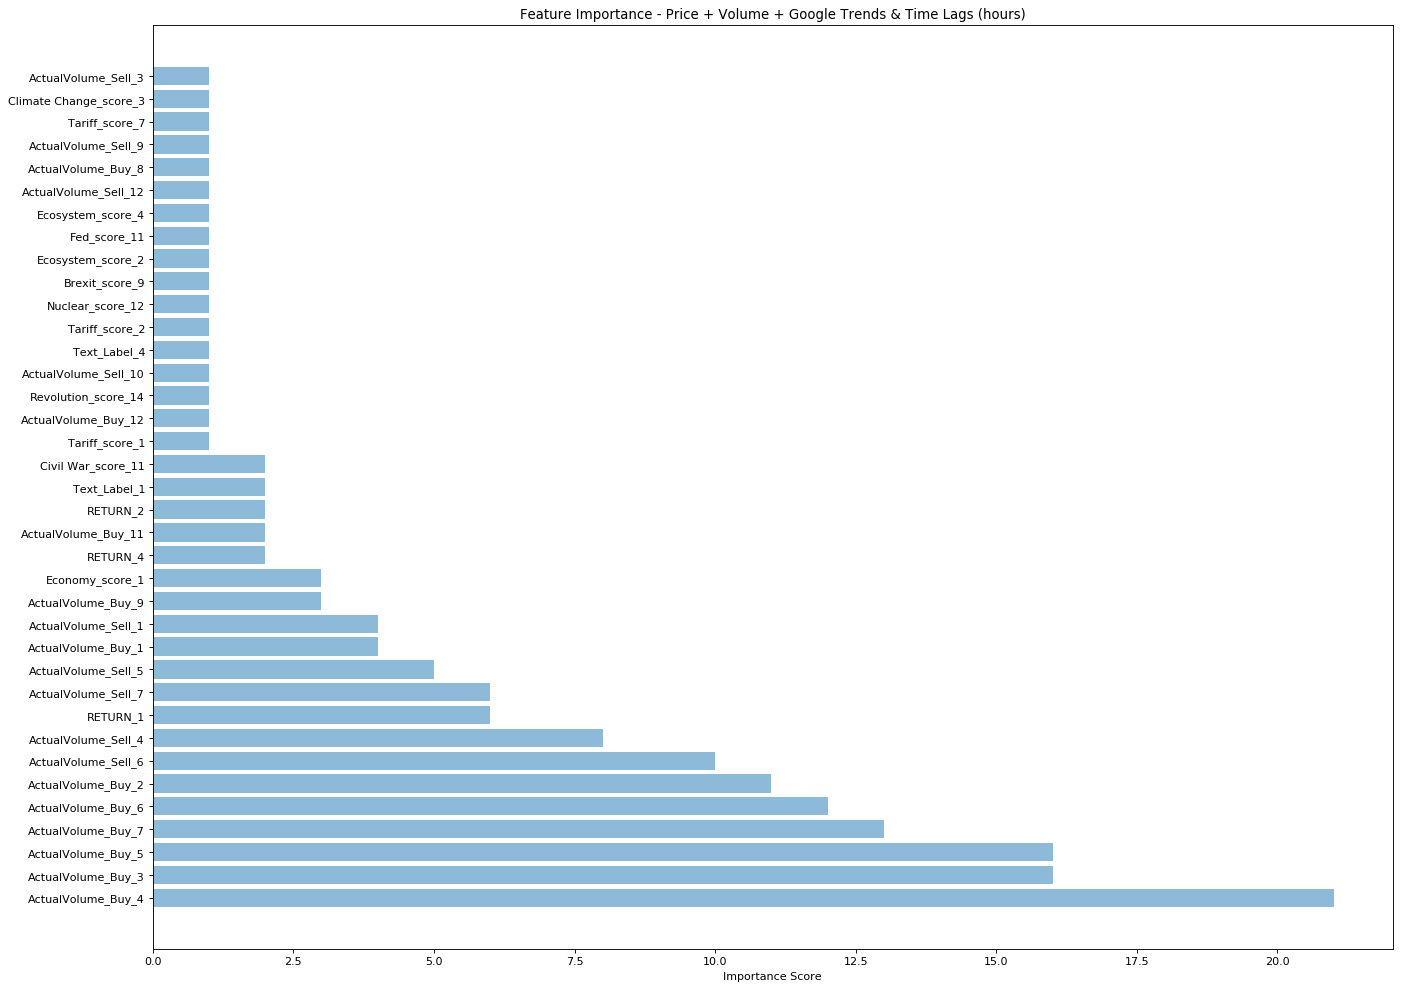

In [33]:
import collections
top_50 = dict(sorted(model_train.model.get_score().items(), key=lambda tup: tup[1],  reverse=True)[:50])

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = list(top_50.keys())
y_pos = np.arange(len(objects))
performance = list(top_50.values())

figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance Score')
plt.title('Feature Importance - Price + Volume + Google Trends & Time Lags (hours)')
plt.show()